In [2]:
import numpy as np
from tqdm import tqdm

from collections import defaultdict, OrderedDict, Counter
from dataclasses import dataclass
import datetime as dt
from itertools import chain
import os
import pathlib
from pathlib import Path
import pandas as pd
import pickle
import unicodedata as ud
from sklearn.model_selection import train_test_split
from time import time
from typing import Dict, Type, Callable, List, Union
import sys
import ujson

import torch
import transformers
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)
from datasets import load_dataset

from aic_nlp_utils.json import read_jsonl, read_json, write_json, write_jsonl
from aic_nlp_utils.encoding import nfc
from aic_nlp_utils.fever import fever_detokenize

%load_ext autoreload
%autoreload 2

## EN

In [2]:
LANG = "en"
FEVER_NLI_ROOT = Path("/mnt/data/factcheck/NLI/nli_fever")
FEVER_NLI_PICKLE_ROOT = Path("/mnt/data/factcheck/NLI/paper_datasets/enfever_nli/pickle")
FEVER_NLI_CLS_ROOT = Path("/mnt/data/factcheck/NLI/nli_fever_cls")

In [104]:
def convert_splits_for_classifier(src_path, dst_dir, seed=1234, dev_size=0.05, tst_size=0.05):
    recs = read_jsonl(src_path)
    cnts = Counter([r["label"] for r in recs])
    print(f"imported {len(recs)} samples with labels: {cnts}")
    l2l = {"SUPPORTS": "s", "REFUTES": "r", "NOT ENOUGH INFO": "n"}
    rets = []
    cids = set()
    missing_ctx = Counter()
    for r in recs:
        claim = nfc(fever_detokenize(r["query"]))
        context = nfc(fever_detokenize(r["context"]))
        label = l2l[r["label"]]
        if len(context) == 0: # some NEI are missing contexts
            missing_ctx[label] += 1
            continue
        cid = r["cid"]
        rets.append({"claim": claim, "context": context, "label": label, "cid": cid})
        cids.add(cid)

    print(f"missing contexts {missing_ctx}")

    rng = np.random.RandomState(seed)
    cids = list(cids)
    rng.shuffle(cids)

    dev_size = int(len(cids) * dev_size)
    tst_size = int(len(cids) * tst_size)
    trn_size = len(cids) - dev_size - tst_size

    trn_cids = set(cids[:trn_size])
    dev_cids = set(cids[trn_size:trn_size+dev_size])
    tst_cids = set(cids[trn_size+dev_size:])

    trn = [r for r in rets if r['cid'] in trn_cids]
    dev = [r for r in rets if r['cid'] in dev_cids]
    tst = [r for r in rets if r['cid'] in tst_cids]

    rng.shuffle(trn)
    rng.shuffle(dev)
    rng.shuffle(tst)
    
    print(f"TRN #{len(trn)}, {Counter([r['label'] for r in trn])}")
    print(f"DEV #{len(dev)}, {Counter([r['label'] for r in dev])}")
    print(f"TST #{len(tst)}, {Counter([r['label'] for r in tst])}")
    
    write_jsonl(Path(dst_dir, "train_nli.jsonl"), trn, mkdir=True)
    write_jsonl(Path(dst_dir, "dev_nli.jsonl"), dev, mkdir=True)
    write_jsonl(Path(dst_dir, "test_nli.jsonl"), tst, mkdir=True)

convert_splits_for_classifier(Path(FEVER_NLI_ROOT, "train_fitems.jsonl"), FEVER_NLI_CLS_ROOT)

imported 208346 samples with labels: Counter({'SUPPORTS': 123594, 'REFUTES': 49113, 'NOT ENOUGH INFO': 35639})
missing contexts Counter({'n': 5194})
TRN #182920, Counter({'s': 111225, 'r': 44191, 'n': 27504})
DEV #10162, Counter({'s': 6178, 'r': 2518, 'n': 1466})
TST #10070, Counter({'s': 6191, 'r': 2404, 'n': 1475})


In [105]:
# # Convert pickles with NEI evidence created by Bertik

# def convert_pickle(src_path, out_path):
#     l2l = {0: "s", 1: "r", 2: "n"}
#     with open(src_path, "rb") as f:
#         d = pickle.load(f)
#         recs = []
#         for sample in d:
#             context = sample.texts[0]
#             assert len(context) > 0
#             claim = sample.texts[1]
#             label = l2l[sample.label]
#             recs.append({"claim": claim, "context": context, "label": label})
#         print(f" #{len(trn)}, {Counter([r['label'] for r in trn])}")
#         return recs


# convert_pickle(Path(FEVER_NLI_PICKLE_ROOT, "trn_examples.p"), Path(FEVER_NLI_CLS_ROOT, "train_nli.jsonl"))

In [106]:
with open("/mnt/data/factcheck/NLI/paper_datasets/enfever_nli/pickle/val_examples.p", "rb") as f:
    d = pickle.load(f)

In [107]:
d[1].texts

['Katherine Matilda "Tilda" Swinton (born 5 November 1960) is a British actress, performance artist, model, and fashion muse, known for her roles in independent and Hollywood films.',
 'Tilda Swinton is a vegan.']

In [108]:
d[1].label

2

# CS

In [2]:
LANG = "cs"
FEVER_NLI_ROOT = Path("/mnt/data/factcheck/NLI/paper_datasets/csfever_nli")
FEVER_NLI_CLS_ROOT = Path("/mnt/data/factcheck/NLI/csfever_nli_cls")

In [3]:
def convert_for_classification(src_path, out_path):
    l2l = {'SUPPORTS': "s", 'REFUTES': "r", 'NOT ENOUGH INFO': "n"}
    d = read_jsonl(src_path)
    recs = []
    missing_ctx = Counter()
    for r in d:
        context = nfc(r["context"])
        # context = '\n\n'.join([nfc(e) for e in r["evidence"]])
        if len(context) == 0:
            missing_ctx[label] += 1
            continue
        claim = nfc(r["query"])
        label = l2l[r["label"]]
        recs.append({"claim": claim, "context": context, "label": label})
    print(f" #{len(recs)}, {Counter([e['label'] for e in recs])}, missing contexts {missing_ctx}")
    write_jsonl(out_path, recs, mkdir=True)


# convert_for_classification(Path(FEVER_NLI_ROOT, "train.jsonl"), Path(FEVER_NLI_CLS_ROOT, "train_nli.jsonl"))
# convert_for_classification(Path(FEVER_NLI_ROOT, "paper_dev.jsonl"), Path(FEVER_NLI_CLS_ROOT, "dev_nli.jsonl"))
# convert_for_classification(Path(FEVER_NLI_ROOT, "paper_test.jsonl"), Path(FEVER_NLI_CLS_ROOT, "test_nli.jsonl"))

# Test Models

In [4]:
raw_nli = load_dataset("json", data_files={
    "train": str(Path(FEVER_NLI_CLS_ROOT, "train_nli.jsonl")),
    "dev": str(Path(FEVER_NLI_CLS_ROOT, "dev_nli.jsonl")),
    "test": str(Path(FEVER_NLI_CLS_ROOT, "test_nli.jsonl"))
    })

Found cached dataset json (/home/drchajan/.cache/huggingface/datasets/json/default-fb3eeb5932352a5e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/3 [00:00<?, ?it/s]

## Seq2Seq Classification

In [ ]:
model_id = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/google/umt5-base_en_US"
id2label = {0: "s", 1: "r", 2: "n"}
label2id = {"s": 0, "r": 1, "n": 1}
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id, device_map="auto", id2label=id2label, label2id=label2id)
# model = AutoModelForSequenceClassification.from_pretrained(model_id, device_map="auto", id2label=id2label, label2id=label2id)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from aic_nlp_utils.batch import batch_apply

def split_predict_generate(model, split, batch_size=128, device="cuda"):
    def predict(inputs):
        X = tokenizer(inputs, max_length=128, padding="max_length", truncation=True, return_tensors="pt")
        input_ids = X["input_ids"].to(device)
        attention_mask = X["attention_mask"].to(device)
        Y = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        # C = tokenizer.batch_decode(Y, skip_special_tokens=False)
        C = tokenizer.batch_decode(Y, skip_special_tokens=True)
        return C
        
    inputs = [[claim, context] for claim, context in zip(split["claim"],  split["context"])]
    # inputs = [[context, claim] for claim, context in zip(split["claim"],  split["context"])] # SWITCHED CTX and CLAIM!!!
    C = batch_apply(predict, inputs, batch_size=batch_size)
    T = [l for l in split["label"]]
    return C, T

C, T = split_predict_generate(model, raw_nli["dev"], device="cuda")
print(f"acc: {accuracy_score(T, C)}")
print(f"F1: {f1_score(T, C, average='macro')}")
# print(f"cm:\n{confusion_matrix(T, C)}")
print()
print(f"cm:\n{confusion_matrix(T, C, labels=['s', 'r', 'n'])}")
print()
print(f"C={Counter(C)}")
print(f"T={Counter(T)}")

acc: 0.8630150457272101
F1: 0.7982163956339497

cm:
[[5848  142  244]
 [ 149 1975  238]
 [ 346  274  953]]

C=Counter({'s': 6343, 'r': 2391, 'n': 1435})
T=Counter({'s': 6234, 'r': 2362, 'n': 1573})


## Sequence Classification Models

In [5]:
model_id = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US/checkpoint-3936"
# model_id = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US_lr1e-6/checkpoint-132864"
# model_id = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli/deepset/xlm-roberta-large-squad2_en_US-20230220_lr1e-6/checkpoint-48416"

# model_id = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_cs_CZ_lr1e-6/checkpoint-2176"
# model_id = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_cs_xCZ_lr1e-6/checkpoint-190720"
# model_id = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli/deepset/xlm-roberta-large-squad2_cs_CZ-20230801_lr1e-6/checkpoint-45184"
tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_id, device_map="auto", id2label=id2label, label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, device_map="auto")

/home/drchajan/devel/python/FC/fc_env_hflarge/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/drchajan/devel/python/FC/fc_env_hflarge/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


/mnt/appl/software/PyTorch/2.0.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [15]:
last = list(list(model.children())[-1].children())[-1]

In [29]:
last.bias

Parameter containing:
tensor([-0.0004,  0.0011, -0.0008], requires_grad=True)

In [27]:
last.weight.shape

torch.Size([3, 1024])

In [33]:
with torch.no_grad():
    last.weight /= 10

In [34]:
last.weight

Parameter containing:
tensor([[-1.3758e-04, -3.0006e-06,  2.2433e-04,  ..., -1.5046e-04,
          1.1701e-04, -7.5604e-06],
        [ 3.1551e-05,  4.7876e-04, -1.6336e-04,  ..., -7.0785e-05,
         -2.5308e-04, -2.5491e-04],
        [-1.0503e-04, -4.8069e-05,  1.6909e-04,  ..., -9.3629e-05,
         -2.0340e-04, -1.0318e-04]], requires_grad=True)

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from aic_nlp_utils.batch import batch_apply

def split_predict(model, split, batch_size=128, device="cuda", max_length=128):
    def predict(inputs):
        X = tokenizer(inputs, max_length=max_length, padding=True, truncation=True, return_tensors="pt")
        input_ids = X["input_ids"].to(device)
        attention_mask = X["attention_mask"].to(device)
        with torch.no_grad():
            Y = model(input_ids=input_ids, attention_mask=attention_mask).logits
            return Y
        
    inputs = [[claim, context] for claim, context in zip(split["claim"],  split["context"])]
    # inputs = [[context, claim] for claim, context in zip(split["claim"],  split["context"])] # SWITCHED CTX and CLAIM!!!
    Ys = batch_apply(predict, inputs, batch_size=batch_size, show_progress=True)
    Y = torch.vstack(Ys)
    C = [model.config.id2label[id_.item()] for id_ in Y.argmax(dim=1)]
    T = [l for l in split["label"]]
    return Y, C, T

# Y, C, T = split_predict(model, raw_nli["test"], device="cuda", max_length=128) # FAST
Y, C, T = split_predict(model, raw_nli["test"], device="cuda", max_length=512) # CORRECT, set to model maximum input length

  0%|          | 0/71 [00:00<?, ?it/s]

In [8]:
print(f"acc: {accuracy_score(T, C)}")
print(f"F1: {f1_score(T, C, average='macro')}")
# print(f"cm:\n{confusion_matrix(T, C)}")
print()
print(f"cm:\n{confusion_matrix(T, C, labels=['s', 'r', 'n'])}")
print()
print(f"C={Counter(C)}")
print(f"T={Counter(T)}")

acc: 0.511728258464262
F1: 0.4554849763669823

cm:
[[2227  879   71]
 [ 771 2066  280]
 [1086 1326  332]]

C=Counter({'r': 4271, 's': 4084, 'n': 683})
T=Counter({'s': 3177, 'r': 3117, 'n': 2744})


### Calibration

Temperature scaling divides all logits by temperature T. Let's find the parameter.

In [18]:
import torch.nn.functional as F

class TemperatureScaling(torch.nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.T = torch.nn.Parameter(data=torch.tensor(10.0)) # single scalar parameter

    def forward(self, Z, apply_softmax=False):
        if apply_softmax:
            return F.softmax(Z/self.T, dim=1)
        else:
            return Z/self.T

scaling_model = TemperatureScaling()
scaling_model.to("cuda")

for p in scaling_model.parameters():
    print(p)

Parameter containing:
tensor(10., device='cuda:0', requires_grad=True)


In [19]:
# target class names to ids
Tid = torch.LongTensor([model.config.label2id[c] for c in T]).to("cuda")
Tid

tensor([2, 1, 0,  ..., 2, 1, 2], device='cuda:0')

In [20]:
from torch.utils.data import Dataset, DataLoader

class CalibrationDataset(Dataset):

    def __init__(self, X, Tcls):
        self.X = X
        self.Tcls = Tcls

    def __len__(self):
        return len(self.Tcls)

    def __getitem__(self, idx):
        return (self.X[idx], self.Tcls[idx])

def train_scaling_model(model, trainloader):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(50):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(inputs)
            # print(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}\tT = {model.T.item()}')
        running_loss = 0.0

    print('Finished Training')

scaling_dataset = CalibrationDataset(Y, Tid)
scaling_dataloader = DataLoader(scaling_dataset, batch_size=16)

train_scaling_model(scaling_model, scaling_dataloader)

[1,   630] loss: 0.673	T = 9.303519248962402
[2,   630] loss: 0.648	T = 8.584953308105469
[3,   630] loss: 0.619	T = 7.8500871658325195
[4,   630] loss: 0.586	T = 7.10518217086792
[5,   630] loss: 0.549	T = 6.357236385345459
[6,   630] loss: 0.508	T = 5.614708423614502
[7,   630] loss: 0.463	T = 4.889533996582031
[8,   630] loss: 0.417	T = 4.201000213623047
[9,   630] loss: 0.375	T = 3.5820393562316895
[10,   630] loss: 0.343	T = 3.083836078643799
[11,   630] loss: 0.326	T = 2.7567238807678223
[12,   630] loss: 0.320	T = 2.5932202339172363
[13,   630] loss: 0.319	T = 2.5268402099609375
[14,   630] loss: 0.319	T = 2.5017316341400146
[15,   630] loss: 0.319	T = 2.492124319076538
[16,   630] loss: 0.319	T = 2.4883320331573486
[17,   630] loss: 0.319	T = 2.4867846965789795
[18,   630] loss: 0.319	T = 2.486128091812134
[19,   630] loss: 0.319	T = 2.485840082168579
[20,   630] loss: 0.319	T = 2.4857089519500732
[21,   630] loss: 0.319	T = 2.4856479167938232
[22,   630] loss: 0.319	T = 2.4856

In [21]:
model.save_pretrained(model_id + "_calibrated")
tokenizer.save_pretrained(model_id + "_calibrated")

('/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US_lr1e-6/checkpoint-132864_calibrated/tokenizer_config.json',
 '/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US_lr1e-6/checkpoint-132864_calibrated/special_tokens_map.json',
 '/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US_lr1e-6/checkpoint-132864_calibrated/sentencepiece.bpe.model',
 '/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US_lr1e-6/checkpoint-132864_calibrated/added_tokens.json',
 '/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US_lr1e-6/checkpoint-132864_calibrated/tokenizer.json')

In [1]:
model

NameError: name 'model' is not defined

In [16]:
Yscaled = scaling_model(Y, apply_softmax=True).detach().cpu().numpy()
Yunscaled = F.softmax(Y, dim=1).detach().cpu().numpy()

In [17]:
Yscaled

array([[0.39834577, 0.33009675, 0.27155748],
       [0.34616068, 0.47853065, 0.17530864],
       [0.10049281, 0.07268194, 0.82682526],
       ...,
       [0.1166447 , 0.07701655, 0.8063387 ],
       [0.19770588, 0.69947165, 0.10282253],
       [0.14999816, 0.7725613 , 0.07744054]], dtype=float32)

In [18]:
Yunscaled

array([[5.2584934e-01, 3.0311456e-01, 1.7103605e-01],
       [2.6883122e-01, 6.9458079e-01, 3.6587946e-02],
       [2.0689077e-03, 8.0033962e-04, 9.9713081e-01],
       ...,
       [3.4414008e-03, 1.0192173e-03, 9.9553937e-01],
       [2.3950586e-02, 9.7252560e-01, 3.5238029e-03],
       [8.1146555e-03, 9.9071687e-01, 1.1684919e-03]], dtype=float32)

0.009800105662532721 0.11779757955088266


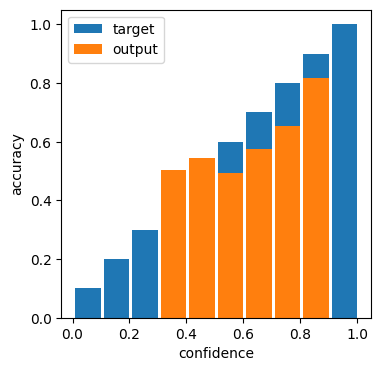

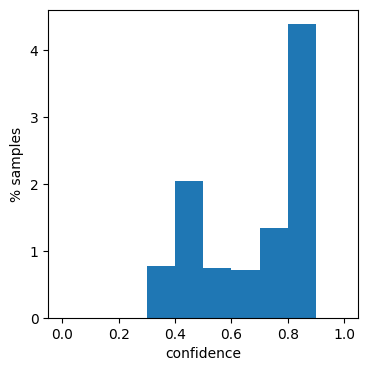

In [19]:
# FROM drchal: calibration.ipynb

import matplotlib.pyplot as plt

class Reliability:
    # based on Guo et al.: "On Calibration of Modern Neural Networks"

    def __init__(self, Y, Tcls, M:int = 10):
        # M: number of bins
        # Y: prediction probabilities (samples, classes)
        # Tcls: target classes (samples, )
        self.M = M
        self.Ymax = Y.max(axis=1)
        self.bin_highs = np.linspace(0, 1, M+1, endpoint=True)[1:]
        self.B = np.digitize(self.Ymax, self.bin_highs)
        Ycls = np.argmax(Y, axis=1)
        accs = []
        confs = []
        bin_sizes = []
        correct = Ycls == Tcls
        for i in range(M):
            idxs = self.B == i
            correct_bin = correct[idxs]
            # print(correct_bin)
            bin_sizes.append(len(correct_bin) )
            if len(correct_bin) > 0:
                accs.append(correct_bin.mean())
                confs.append(self.Ymax[idxs].mean())
            else:
                accs.append(np.NaN)
                confs.append(np.NaN)
        self.accs = np.array(accs)
        self.confs = np.array(confs)
        self.bin_sizes = np.array(bin_sizes)
        # print(self.accs)
        # print(self.confs)

    def ece(self):
        # print(self.bin_sizes)
        e = np.nanmean(self.bin_sizes * np.abs(self.accs - self.confs)) / len(self.B)
        return e

    def mce(self):
        # print(self.bin_sizes)
        e = np.nanmax(np.abs(self.accs - self.confs))
        return e

    def diagram(self):
        x = np.nan_to_num(self.bin_highs, 0.0)
        # y = x * (1-np.isnan(self.accs))
        y = x
        y2 =  np.nan_to_num(self.accs)
        fig = plt.subplots(figsize=(4, 4))
        width = 0.9 / self.M
        plt.bar(x, y, align='edge', width=-width, label="target")
        plt.bar(x, y2, align='edge', width=-width, label="output")
        plt.legend()
        plt.xlabel("confidence")
        plt.ylabel("accuracy")
        return fig
    
    def confidence_hist(self):
        fig = plt.subplots(figsize=(4, 4))
        plt.hist(self.Ymax.ravel(), density=True, range=(0,1))
        plt.xlabel("confidence")
        plt.ylabel("% samples")
        return fig


reliability = Reliability(Yscaled, Tid.cpu().numpy(), M=10)
print(reliability.ece(), reliability.mce())
reliability.diagram();
reliability.confidence_hist();

0.02741590873183852 0.3507188736067878


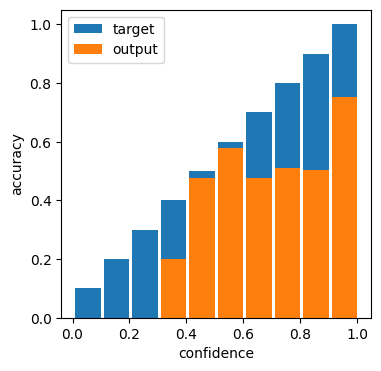

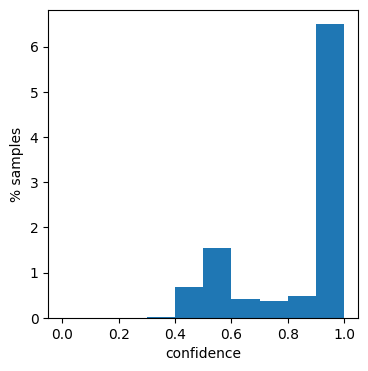

In [20]:
reliability = Reliability(Yunscaled, Tid.cpu().numpy(), M=10)
print(reliability.ece(), reliability.mce())
reliability.diagram();
reliability.confidence_hist();

## Seq2Seq Probabilities

In [ ]:
def predict(inputs, device="cuda"):
    with torch.no_grad():
        X = tokenizer(inputs, max_length=128, padding="max_length", truncation=True, return_tensors="pt")
        # print(X)
        # print(tokenizer.batch_decode(X['input_ids']))
        input_ids = X["input_ids"].to(device)
        attention_mask = X["attention_mask"].to(device)
        # Y = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        print(input_ids)
        decoder_input_ids = tokenizer('<pad>', add_special_tokens=False, return_tensors='pt').input_ids.to(device)
        print(decoder_input_ids)

        Y = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
        # C = tokenizer.batch_decode(Y, skip_special_tokens=False)
        # return Y, C
        return Y

# Y = predict([[raw_nli["dev"][0]["claim"], raw_nli["dev"][0]["context"]]], device="cpu") # s
# Y = predict([[raw_nli["dev"][1]["claim"], raw_nli["dev"][1]["context"]]], device="cpu") # r
Y = predict([[raw_nli["dev"][14]["claim"], raw_nli["dev"][14]["context"]]], device="cpu") # n

tensor([[  4202,  38460,  44569,    463,  33892,    315,  33809, 173850,    764,
            289,    669,    387,    274,      1,   4202,  38460,  44569,    463,
            274,   1974,    661,    367,   4799,   9376,    289,    379, 172369,
            275,   8517,  18448,    955,    275,  93040,   3482,  75065,    275,
         171022,    313,    678,    274,    436,    274, 203440,    610,    275,
           3072,   2345,    275,    748, 235033, 184318,    275,    273, 157681,
            331,    275,    429,  59835,    280,  81498,    275, 199864,    326,
            275, 154226,  19568,    273,  81498,    275,  89604,    275,    333,
            273, 126058,  72847,    292,    274,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,    

In [ ]:
for id_ in Y.logits[0][0].argsort(descending=True)[:10]:
    id_ = id_.item()
    print(tokenizer.convert_ids_to_tokens(id_), Y.logits[0][0][id_].item())

▁n 14.080589294433594
▁r 10.552347183227539
▁s 9.771906852722168
▁N -2.247624158859253
▁н -2.677797794342041
n -2.713212251663208
▁nm -2.7915496826171875
▁m -3.119760513305664
▁l -3.2021236419677734
▁nj -3.211195468902588


In [ ]:
Y.logits[0][0][382]

tensor(11.1417)

In [ ]:
s_id = 382
r_id = 1059
n_id = 700
eos_id = tokenizer.convert_tokens_to_ids("</s>")

ids = [s_id, r_id, n_id, eos_id]
logits = [Y.logits[0][0][id_].item() for id_ in ids]
ids

[382, 1059, 700, 1]

In [ ]:
logits

[12.598245620727539, 9.146134376525879, 9.729085922241211, -8.055418014526367]

In [ ]:
Y
Y

Seq2SeqLMOutput(loss=None, logits=tensor([[[-21.2719,  -8.0554, -20.2493,  ..., -21.8075, -21.5201, -21.6181]]]), past_key_values=((tensor([[[[-3.4952e-01,  5.3054e-01,  9.3459e-02,  8.8246e-01,  1.1219e+00,
           -2.0494e-01,  6.4216e-01, -8.5276e-01, -2.2326e+00, -4.0918e+00,
           -4.8337e-01,  6.5037e-01,  3.6736e-01,  3.0607e+00, -1.0481e+00,
           -1.3723e-01, -3.4112e-02, -6.6874e-01, -1.3780e+00, -4.4300e-01,
           -2.4969e+00, -9.3707e-01,  2.6762e+00,  2.0431e+00,  5.1601e-01,
           -2.3992e+00, -4.5098e-01, -3.8547e-02, -1.9710e-01, -5.4999e-01,
           -3.2642e+00,  1.0844e+00, -1.3043e+00,  1.4313e-01, -1.5442e+00,
           -1.3992e-01,  3.6634e+00,  1.1119e+00, -8.0305e-01, -3.4503e-01,
           -5.8276e-01, -1.1344e+00, -7.7211e-01, -1.5572e-01,  9.2353e-01,
            4.4123e-01, -4.8001e-01,  9.6148e-01,  1.0028e+00,  2.3238e-01,
           -4.0417e-01,  6.1111e-01, -1.1823e+00, -4.2476e+00, -1.3565e+00,
            3.4508e+00,  1.8072e